<a href="https://colab.research.google.com/github/Muthumeena-CYBER/crop_prediction_app/blob/main/disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")


GPU Available: True
GPU Name: Tesla T4


In [74]:
import os

dataset_path = "/content/drive/MyDrive/new-plant-diseases-dataset/DATASET1/PlantVillage-Dataset"

# List all files and subdirectories
print("Contents inside 'PlantVillage-Dataset':")
print(os.listdir(dataset_path))


Contents inside 'PlantVillage-Dataset':
['.git', '.gitignore', 'create_data_distribution.py', 'create_db.py', 'generated_for_paper', 'generate_data_color-20-80.sh', 'generate_data_color-40-60.sh', 'generate_data_color-50-50.sh', 'generate_data_color-60-40.sh', 'generate_data_color-80-20.sh', 'generate_data_for_SVM.py', 'generate_data_grayscale-20-80.sh', 'generate_data_grayscale-40-60.sh', 'generate_data_grayscale-50-50.sh', 'generate_data_grayscale-60-40.sh', 'generate_data_grayscale-80-20.sh', 'generate_data_segmented-20-80.sh', 'generate_data_segmented-40-60.sh', 'generate_data_segmented-50-50.sh', 'generate_data_segmented-60-40.sh', 'generate_data_segmented-80-20.sh', 'generate_lmdb.sh', 'generate_mapstring.py', 'leaf-map.json', 'leaf_grouping', 'raw', 'README.md', 'run_all.sh', 'slurm-476480.out', 'slurm-476481.out', 'slurm-476482.out', 'slurm-476483.out', 'slurm-476484.out', 'slurm-476485.out', 'slurm-476486.out', 'slurm-476487.out', 'slurm-476488.out', 'slurm-476489.out', 'slurm

In [75]:
!pip install torchsummary

In [76]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

%matplotlib inline

In [6]:
import os

data_dir = "../content/drive/MyDrive/new-plant-diseases-dataset/DATASET1/PlantVillage-Dataset/data_distribution"

train_dir = data_dir + "/train"
valid_dir = data_dir + "/test"
diseases = os.listdir(train_dir)


In [7]:
print(diseases)
print("Total disease classes are: {}".format(len(diseases)))

['Apple___Apple_scab', 'Apple___Black_rot', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Apple___Cedar_apple_rust', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___healthy', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Target_Spot', 'Tomato___Septoria_leaf_spo

In [8]:
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 38


In [9]:
import shutil
import os

# Define the path
checkpoints_path = os.path.join(train_dir, ".ipynb_checkpoints")

# Check if it exists and delete
if os.path.exists(checkpoints_path):
    shutil.rmtree(checkpoints_path)  # Delete the folder
    print("✅ .ipynb_checkpoints deleted!")
else:
    print("🚫 .ipynb_checkpoints not found.")


🚫 .ipynb_checkpoints not found.


In [10]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [11]:
print(f"Unique Plants are: \n{plants}")
print("Number of plants: {}".format(len(plants)))
print("Number of diseases: {}".format(NumberOfDiseases))

Unique Plants are: 
['Apple', 'Corn_(maize)', 'Grape', 'Orange', 'Peach', 'Pepper,_bell', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato', 'Blueberry', 'Cherry_(including_sour)']
Number of plants: 14
Number of diseases: 26


In [12]:
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))

# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

no. of images
Apple___Apple_scab                                            111
Apple___Black_rot                                             114
Corn_(maize)___healthy                                        212
Grape___Black_rot                                             187
Grape___Esca_(Black_Measles)                                  233
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)                    159
Grape___healthy                                                67
Orange___Haunglongbing_(Citrus_greening)                      847
Peach___Bacterial_spot                                        386
Peach___healthy                                                74
Pepper,_bell___Bacterial_spot                                 158
Pepper,_bell___healthy                                        241
Apple___Cedar_apple_rust                                       39
Potato___Early_blight                                         153
Potato___Late_blight                                          168
Potato___healthy                                               25
Raspberry___healthy                                            44
Soybean___healthy                                             885
Squash___Powdery_mildew                                       270
Strawberry___Leaf_scorch                                      187
Strawberry___healthy                                           84
Tomato___Bacterial_spot                                       297
Tomato___Early_blight                                         147
Apple___healthy                                               288
Blueberry___healthy                                           239
Cherry_(including_sour)___Powdery_mildew                      181
Cherry_(including_sour)___healthy                             132
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot             83
Corn_(maize)___Common_rust_                                   199
Corn_(maize)___Northern_Leaf_Blight                           132
Tomato___healthy                                              224
Tomato___Tomato_mosaic_virus                                   65
Tomato___Tomato_Yellow_Leaf_Curl_Virus                        897
Tomato___Target_Spot                                          211
Tomato___Septoria_leaf_spot                                   275
Tomato___Spider_mites Two-spotted_spider_mite                 300
Tomato___Leaf_Mold                                            146
Tomato___Late_blight                                          291

Text(0.5, 1.0, 'Images per each class of plant disease')

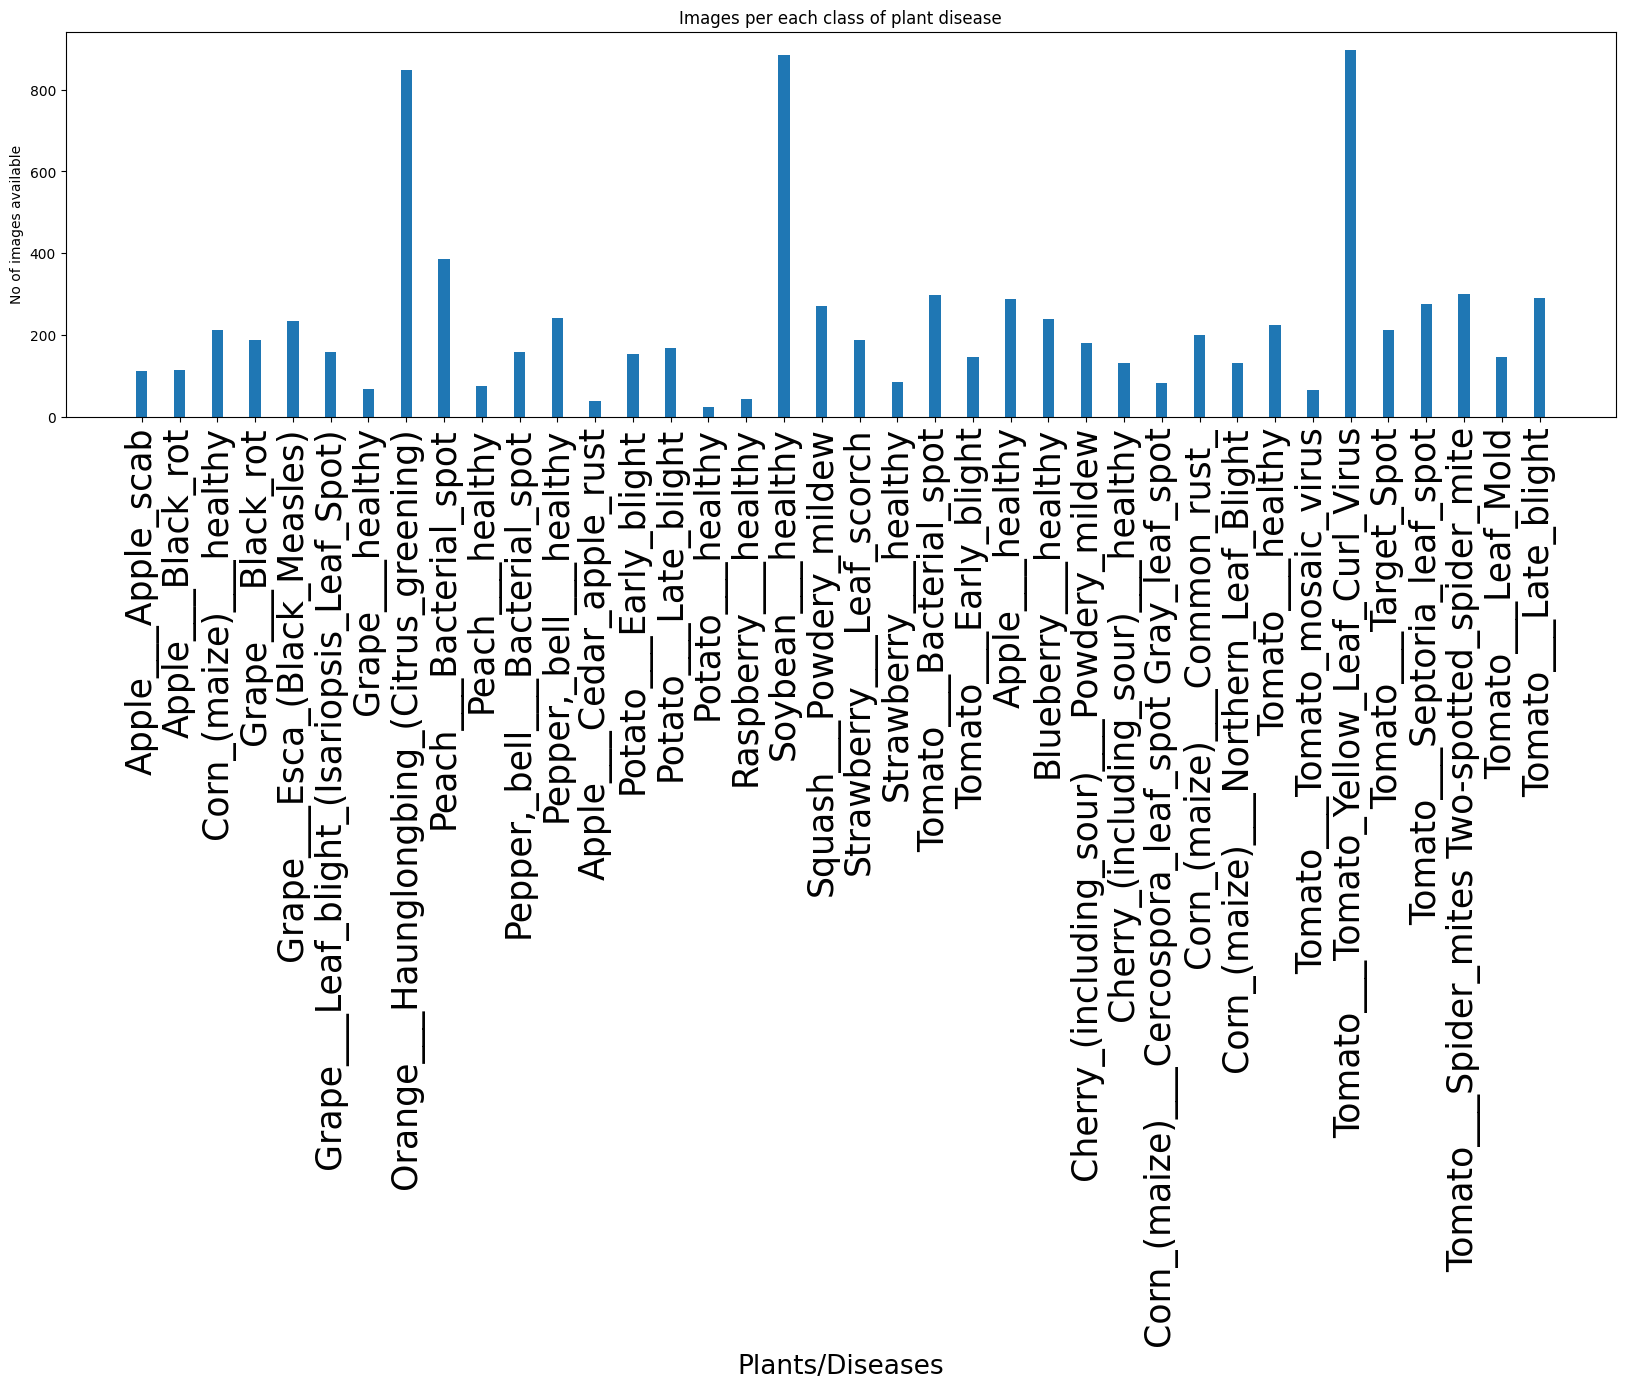

In [13]:
# plotting number of images available for each disease
index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=19)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=25, rotation=90)
plt.title('Images per each class of plant disease')

In [14]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 8751 images for training


In [15]:
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor())

In [16]:
img, label = train[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [72]:
len(train.classes)

38

In [18]:
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Label :Apple___Apple_scab(0)


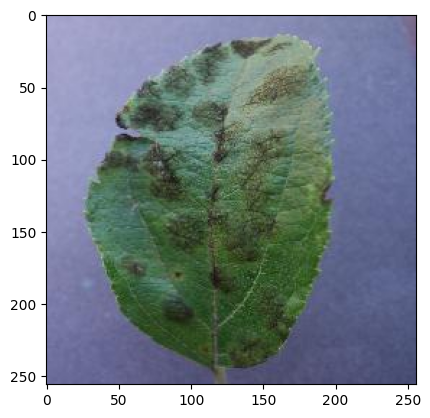

In [19]:
show_image(*train[110])

In [20]:
random_seed = 7
torch.manual_seed(random_seed)

In [21]:
# setting the batch size
batch_size = 32

In [22]:
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [23]:
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

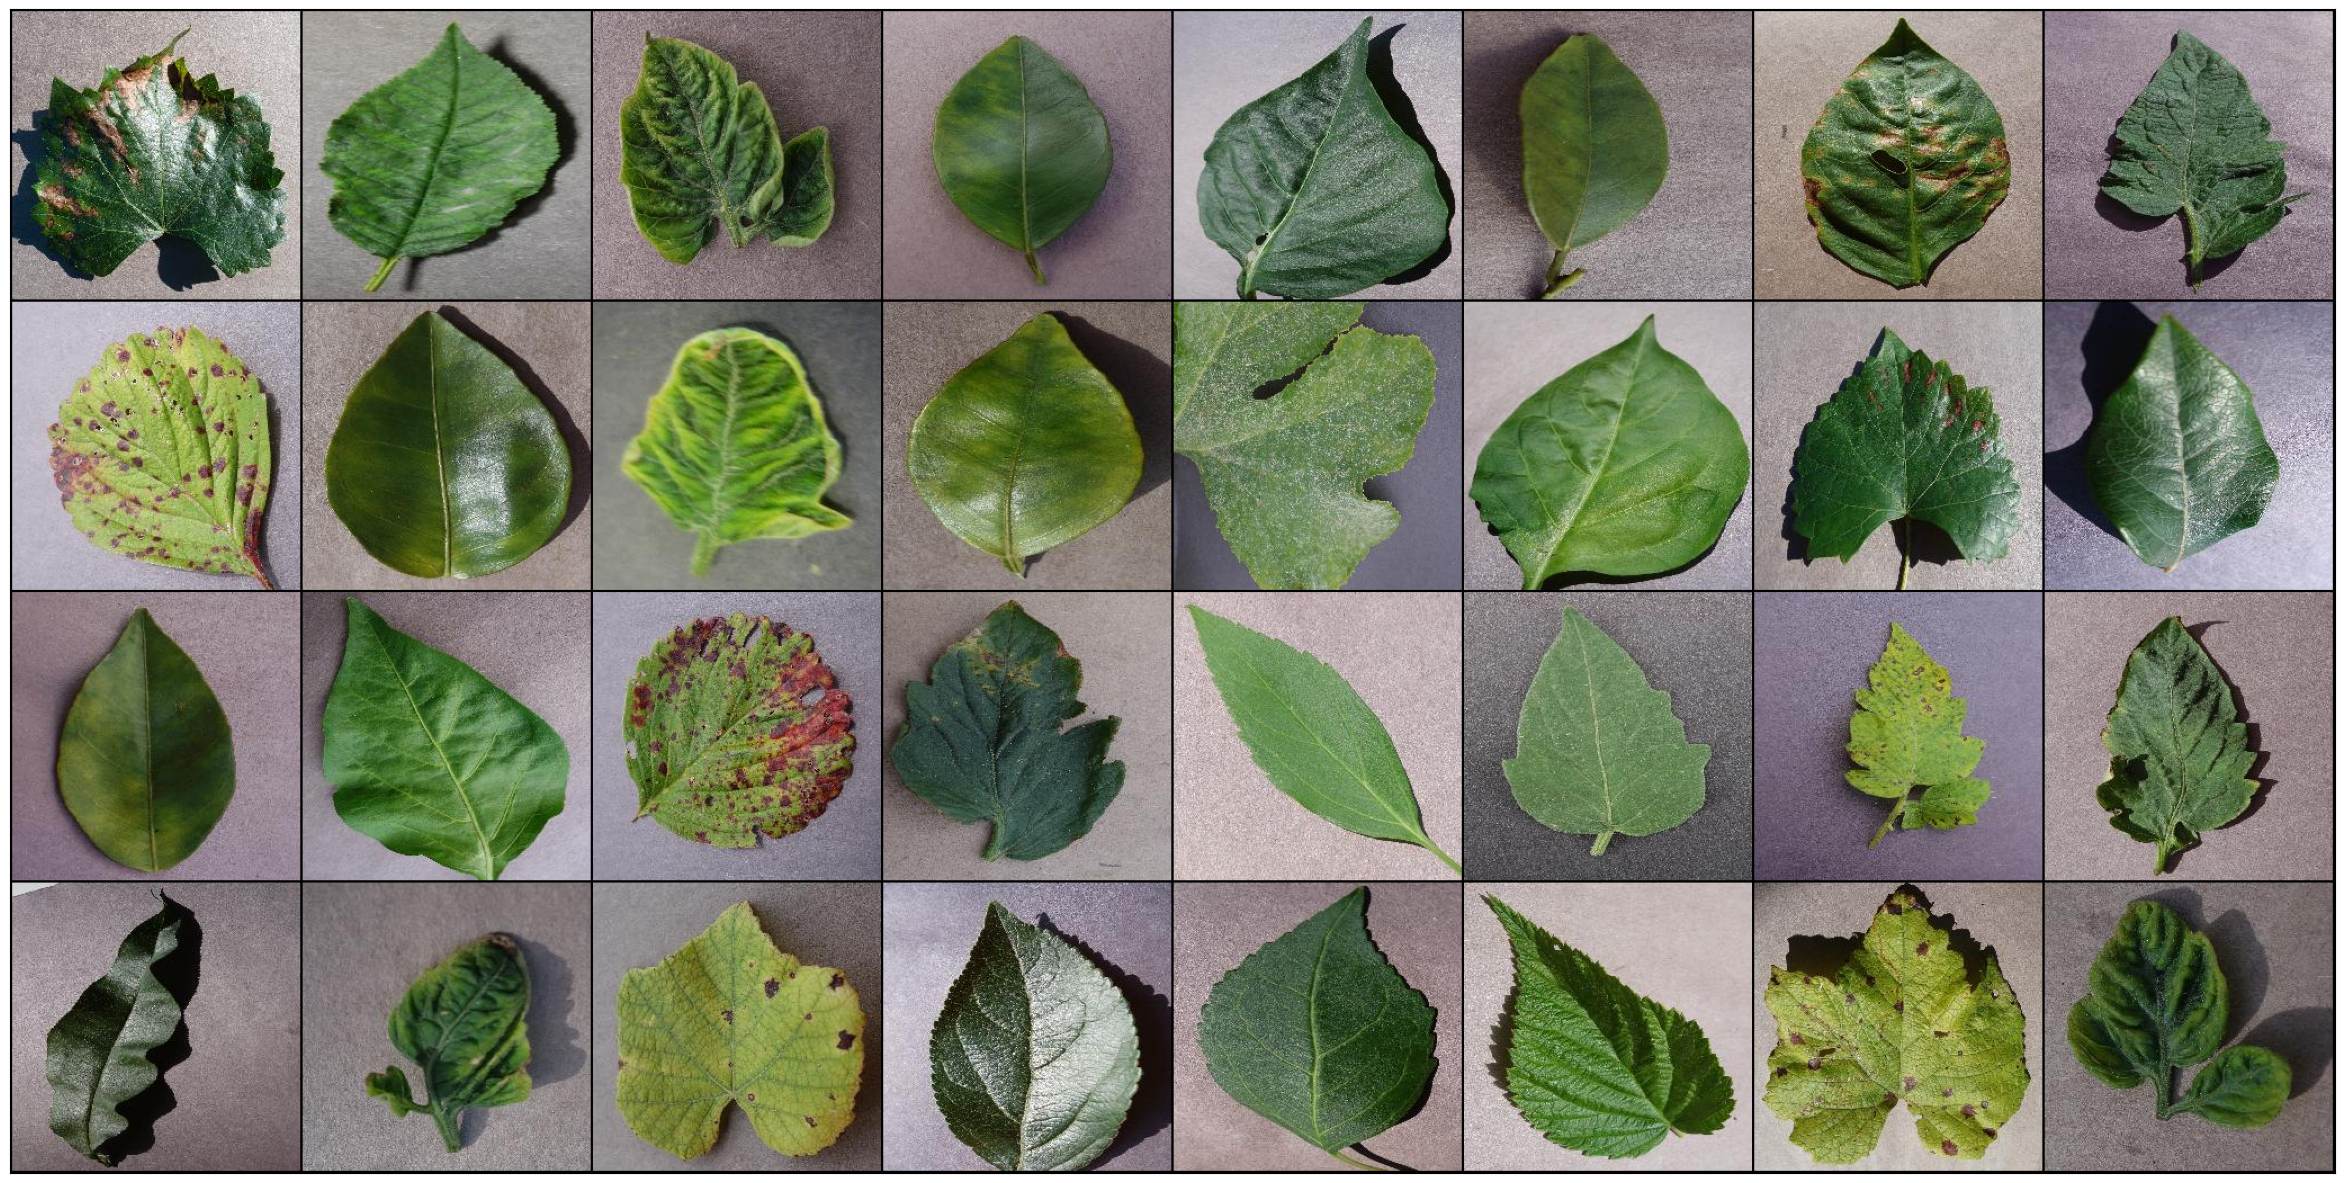

In [24]:
show_batch(train_dl)

In [25]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [77]:
device = get_default_device()
device

device(type='cuda')

In [78]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [28]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [29]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [79]:
# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()

        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))

    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [80]:
model = to_device(ResNet9(3, len(train.classes)), device)
model


ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [81]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [33]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [34]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))


    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()


        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history


In [35]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 27.6 s, sys: 4.5 s, total: 32.1 s
Wall time: 1min 3s


[{'val_loss': tensor(3.6332, device='cuda:0'), 'val_accuracy': tensor(0.0287)}]

In [36]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [37]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=1e-4,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00812, train_loss: 2.0620, val_loss: 1.6126, val_acc: 0.5993
Epoch [1], last_lr: 0.00000, train_loss: 0.5036, val_loss: 0.2697, val_acc: 0.9186
CPU times: user 2min 12s, sys: 1min 30s, total: 3min 42s
Wall time: 14min 1s


In [38]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'].cpu().numpy() for x in history] # Move tensors to CPU before converting to NumPy
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

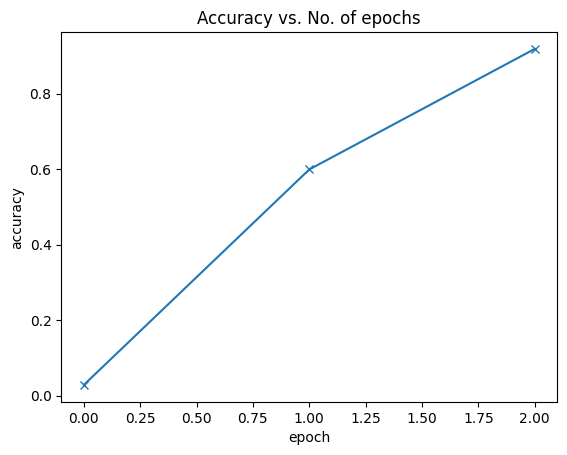

In [39]:
plot_accuracies(history)

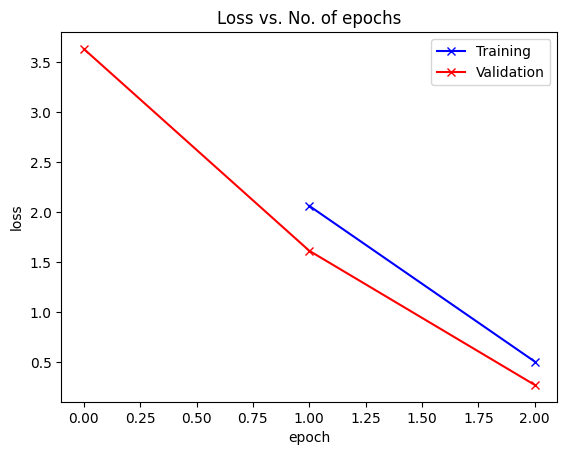

In [40]:
plot_losses(history)

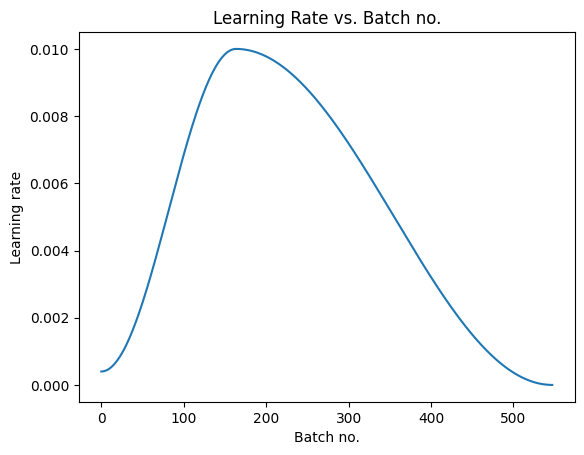

In [41]:
plot_lrs(history)

In [42]:
import os
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
# /content/drive/MyDrive/new-plant-diseases-dataset/DATASET1/PlantVillage-Dataset/data_distribution/test
test_dir = "../content/drive/MyDrive/new-plant-diseases-dataset/DATASET1/PlantVillage-Dataset/data_distribution/test"
test = ImageFolder(test_dir, transform=transforms.ToTensor())


In [43]:
import shutil
import os

# Define the path
checkpoints_path = os.path.join(test_dir, ".ipynb_checkpoints")

# Check if it exists and delete
if os.path.exists(checkpoints_path):
    shutil.rmtree(checkpoints_path)  # Delete the folder
    print("✅ .ipynb_checkpoints deleted!")
else:
    print("🚫 .ipynb_checkpoints not found.")

🚫 .ipynb_checkpoints not found.


In [44]:
test_images = sorted(os.listdir(test_dir +'/')) # since images in test folder are in alphabetical order
test_images

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [67]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]

Label: Apple___Apple_scab , Predicted: Apple___Black_rot


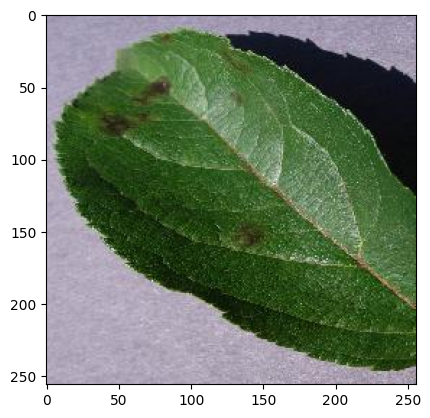

In [46]:
# predicting first image
img, label = test[27]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))

In [47]:
print("Total test samples:", len(test))
print("Total test_images:", len(test_images))


Total test samples: 10547
Total test_images: 38


In [48]:
for i, (img, label) in enumerate(test):
    if i >= len(test_images):  # Avoid index error
        break
    print('Label:', test_images[i], ', Predicted:', predict_image(img, model))


Label: Apple___Apple_scab , Predicted: Apple___Apple_scab
Label: Apple___Black_rot , Predicted: Apple___Apple_scab
Label: Apple___Cedar_apple_rust , Predicted: Apple___Apple_scab
Label: Apple___healthy , Predicted: Apple___Apple_scab
Label: Blueberry___healthy , Predicted: Apple___Apple_scab
Label: Cherry_(including_sour)___Powdery_mildew , Predicted: Apple___Apple_scab
Label: Cherry_(including_sour)___healthy , Predicted: Tomato___Late_blight
Label: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot , Predicted: Apple___Apple_scab
Label: Corn_(maize)___Common_rust_ , Predicted: Apple___Apple_scab
Label: Corn_(maize)___Northern_Leaf_Blight , Predicted: Peach___Bacterial_spot
Label: Corn_(maize)___healthy , Predicted: Apple___Apple_scab
Label: Grape___Black_rot , Predicted: Apple___Apple_scab
Label: Grape___Esca_(Black_Measles) , Predicted: Apple___Apple_scab
Label: Grape___Leaf_blight_(Isariopsis_Leaf_Spot) , Predicted: Apple___Apple_scab
Label: Grape___healthy , Predicted: Tomato___Se

In [56]:
# saving to the kaggle working directory
PATH = './plant-disease-model.pth'
torch.save(model.state_dict(), PATH)

In [57]:
# saving the entire model to working directory
PATH = './plant-disease-model-complete.pth'
torch.save(model, PATH)

In [49]:
!pip install gradio
import gradio as gr

In [86]:
def predict_leaf_disease(image):
    # Load your trained model and process the image
    r=predict_image(image,model)
    return r

interface = gr.Interface(
    fn=predict_leaf_disease,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Leaf Disease Detection",
    description="Upload a plant leaf image and get the predicted disease."
)

interface.launch(share=True)  # Generates a public link


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b209025eeb9a3eb2cd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Label: Apple___Black_rot , Predicted: Grape___Black_rot


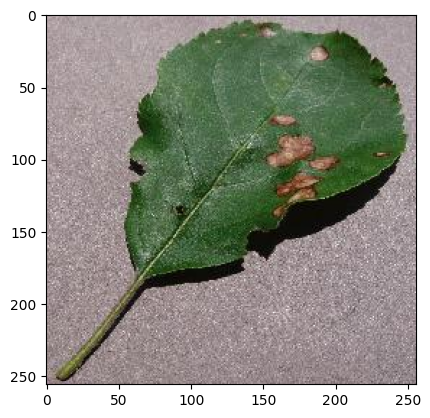

In [93]:
import torch
import matplotlib.pyplot as plt

# Ensure the device is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(data, device):
    return data.to(device, non_blocking=True)

def predict_image(img, model):
    """Converts image to array and returns the predicted class with highest probability"""
    xb = to_device(img.unsqueeze(0), device)  # Convert to batch of 1
    yb = model(xb)  # Get predictions
    _, preds = torch.max(yb, dim=1)  # Get index of highest probability
    return test.classes[preds[0].item()]  # Retrieve class label

# Predicting the 28th image in the test set
img, label = test[166]  # Assuming test is a dataset like ImageFolder
plt.imshow(img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
print('Label:', test.classes[label], ', Predicted:', predict_image(img, model))


In [88]:
model.eval()  # Set model to evaluation mode


ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [90]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize if required
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Match training normalization
])


In [1]:
import torch
import gradio as gr
import matplotlib.pyplot as plt
from torchvision import transforms

# Ensure the device is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(data, device):
    return data.to(device, non_blocking=True)

def predict_image(img, model):
    """Converts image to array and returns the predicted class with highest probability"""
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    img = transform(img)
    xb = to_device(img.unsqueeze(0), device)  # Convert to batch of 1
    yb = model(xb)  # Get predictions
    _, preds = torch.max(yb, dim=1)  # Get index of highest probability
    return test.classes[preds[0].item()]  # Retrieve class label

def classify(img):
    label = predict_image(img, model)
    return f"Predicted Class: {label}"

# Gradio Interface
demo = gr.Interface(
    fn=classify,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox()
)

demo.launch()


ModuleNotFoundError: No module named 'gradio'